## Assignment
Name: Daan Steur

Student number: 379943

Supervisor: Drs. Bart Barnard

Course: DSLS Data Science 3: Supervised machine learning

Date: 29th of may

### Prediction of Blood Pressure Abnormality based on patient health information. 

#### Assignment 
Load, inspect and clean the data. Split the data into a training set and a validation set and a test set. Use a simple classifier as a baseline. Train various classifiers. Motivate your choice in relation to the characteristics of the dataset. Try to combine them into an ensemble learning model that outperforms all of the others

#### Data
Blood Pressure Data for disease Prediction:
- Blood_Pressure_Abnormality, Chronic_kidney_disease, Adrenal_and_thyroid_disorders, Pregnancy, Smoking
- Patient_Number, , Level_of_Hemoglobin, Genetic_Pedigree_Coefficient, Age, BMI, Sex, Physical_activity, salt_content_in_the_diet, alcohol_consumption_per_day, Level_of_Stress



Data & packages

In [565]:
# load packages
# base
import pandas as pd
import numpy as np

# plotting and data visualization
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import pyplot
from exploration import *

# Modeling
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedStratifiedKFold
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import StackingClassifier


In [566]:
# load data
data = pd.read_csv("data.csv")
# drop patient ids which is not a relevant component and pregnancy which has to many missing values, to be useful for our purpose. 
data.drop(columns= ['Patient_Number','Pregnancy'])
# reorder columns
data = data[["Blood_Pressure_Abnormality",
            "Chronic_kidney_disease",
             "Adrenal_and_thyroid_disorders",
             "Level_of_Hemoglobin",
             "Genetic_Pedigree_Coefficient",
             "Age",
             "BMI",
             "Sex",
             "Smoking",
             "Physical_activity",
             "salt_content_in_the_diet",
             "alcohol_consumption_per_day",
             "Level_of_Stress",
]]
# rename 0 and 1 for easier understanding of the data
data["Sex"] =  data["Sex"].replace({1: "male", 0: "female"})
data["Chronic_kidney_disease"] =  data["Chronic_kidney_disease"].replace({1: "diseased", 0: "healthy"})
data["Adrenal_and_thyroid_disorders"] =  data["Adrenal_and_thyroid_disorders"].replace({1: "diseased", 0: "healthy"})
data["Blood_Pressure_Abnormality"] =  data["Blood_Pressure_Abnormality"].replace({1: "diseased", 0: "healthy"})
# data["Smoking"] = data["Smoking"].replace({1: "yes", 0: "no"})
data.head()

,Blood_Pressure_Abnormality,Chronic_kidney_disease,Adrenal_and_thyroid_disorders,Level_of_Hemoglobin,Genetic_Pedigree_Coefficient,Age,BMI,Sex,Smoking,Physical_activity,salt_content_in_the_diet,alcohol_consumption_per_day,Level_of_Stress
0,diseased,diseased,diseased,11.28,0.90,34,23,male,0,45961,48071,NaN,2
1,healthy,healthy,healthy,9.75,0.23,54,33,male,0,26106,25333,205.0,3
2,diseased,diseased,healthy,10.79,0.91,70,49,female,0,9995,29465,67.0,2
3,healthy,diseased,healthy,11.00,0.43,71,50,female,0,10635,7439,242.0,1
4,diseased,healthy,healthy,14.17,0.83,52,19,female,0,15619,49644,397.0,2


Data Exploration (EDA)

c:\Users\31613\Desktop\Git repositories\DSLS-DS3-Machine-learning\Supervised-learning\exploration.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_num.sort_index(axis=1, inplace=True, key=lambda x: x.str.lower())


                             N Obs    N Missing    N Valid    % Complete    N Unique      Mean        SD    Median       MAD    Min       Max    Skewness    Kurtosis  CV
-------------------------  -------  -----------  ---------  ------------  ----------  --------  --------  --------  --------  -----  --------  ----------  ----------  ----
Age                           2000            0       2000         100            58     46.56     17.11     46        22.24   18       75           0.02       -1.25  0.37
alcohol_consumption_per_d     2000          242       1758          87.9         488    251.01    143.65    250       186.81    0      499          -0.01       -1.22
BMI                           2000            0       2000         100            41     30.08     11.76     30        14.83   10       50          -0.02       -1.18  0.39
Genetic_Pedigree_Coeffici     2000           92       1908          95.4         101      0.49      0.29      0.49      0.37    0        1          

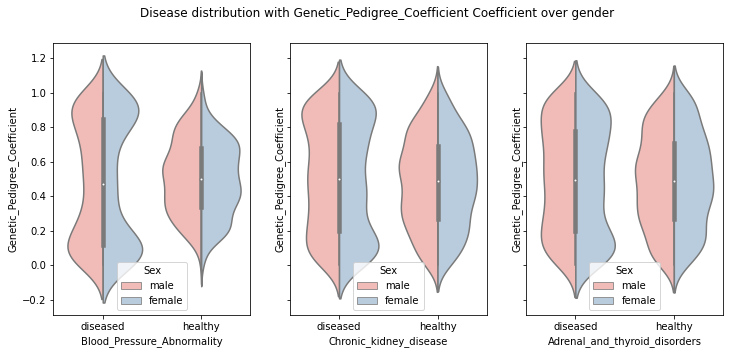

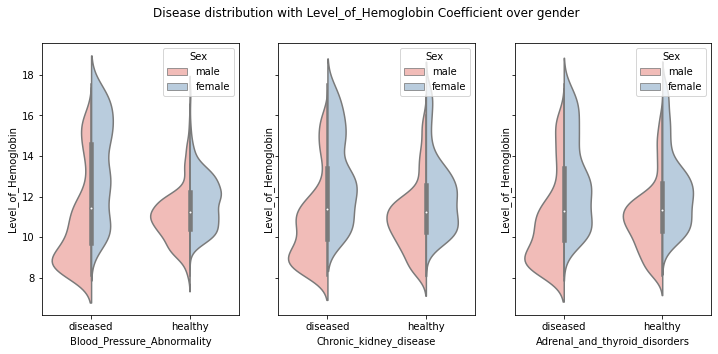

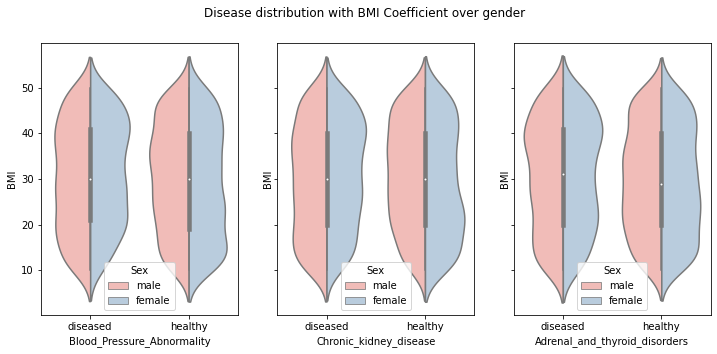

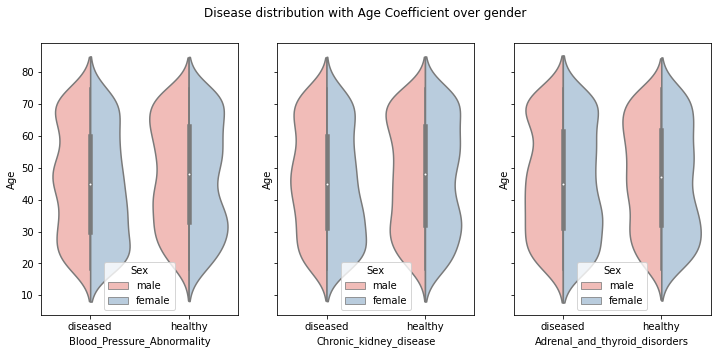

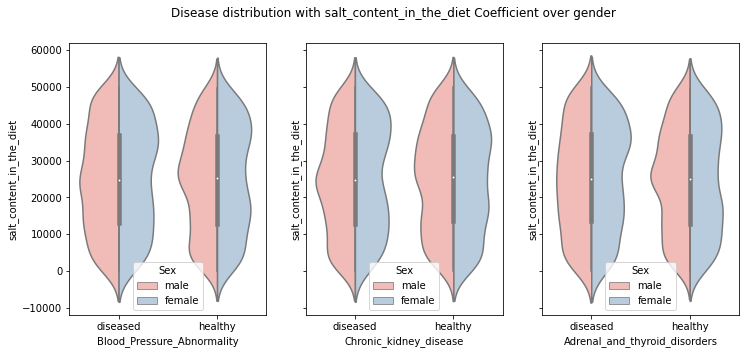

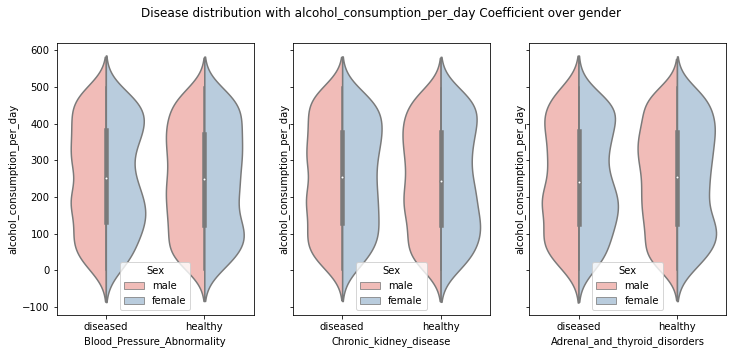

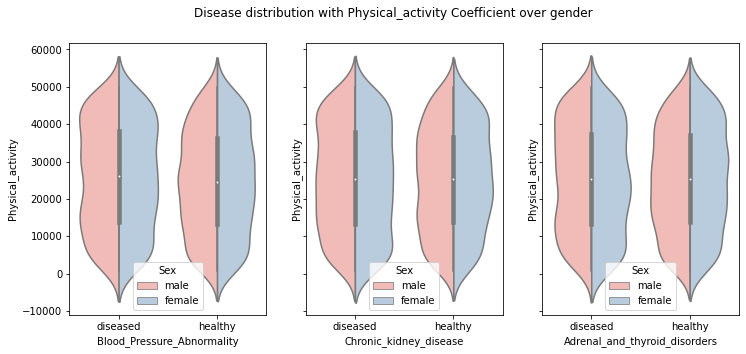

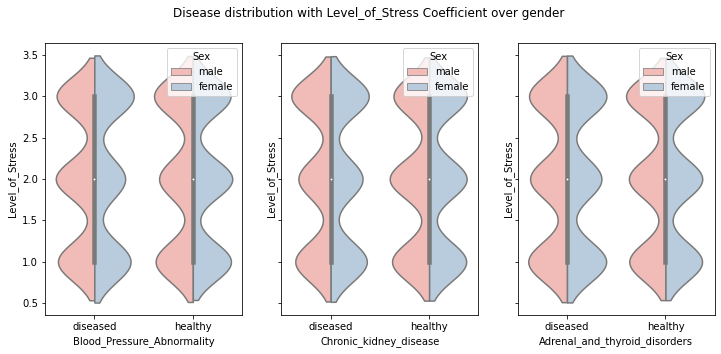

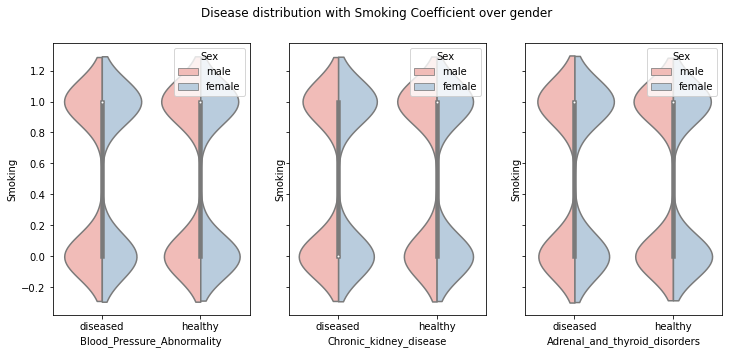

In [567]:
# overview statistics of the data
exploration.data_exploration_csv("data.csv")
exploration.Categorical_Variables_csv("data.csv")

# violin plotting of the data based on healthy and diseased and gender to find components of interest. 
labels = [["Genetic_Pedigree_Coefficient", "Level_of_Hemoglobin", "BMI", "Age", "salt_content_in_the_diet", "alcohol_consumption_per_day", "Physical_activity", "Level_of_Stress", "Smoking"]]
for label in labels:
    for i in label:
        exploration.violin_plot(i, data)


Result: Based on previous analysis factors that have the biggest influence on Blood_Pressure_Abnormality are genetic pedigree, level of hemoglobin,  alcohol consumption per day & Age.

<AxesSubplot:>

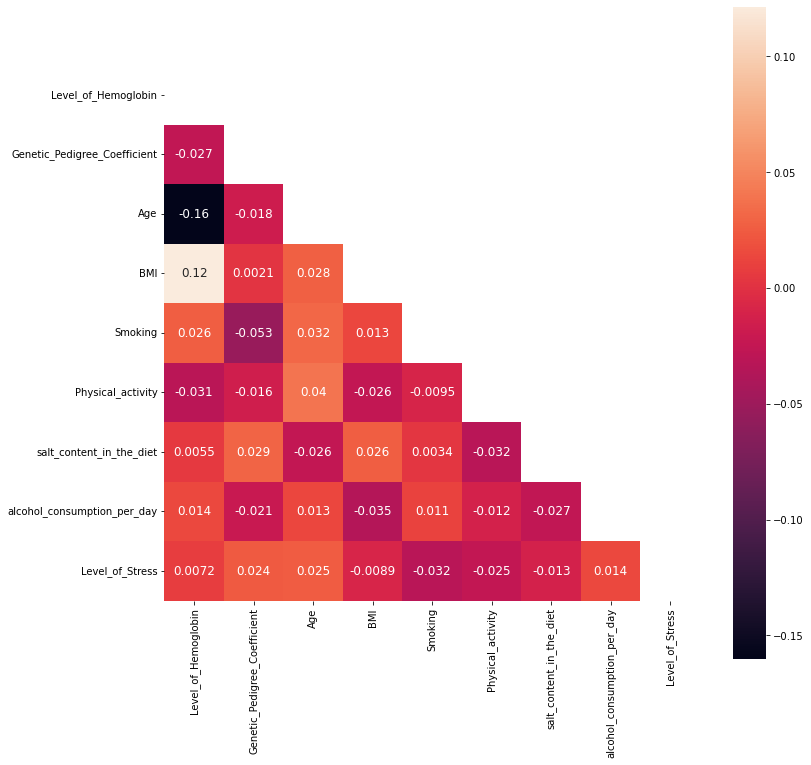

In [568]:
# drop rows with na values
data = data.dropna(subset=["Genetic_Pedigree_Coefficient","alcohol_consumption_per_day"])

# Calculate correlation between each pair of variable
corr_matrix=data.corr(method='pearson')
# Can be great to plot only a half matrix
# Generate a mask for the upper triangle
mask = np.zeros_like(corr_matrix)
mask[np.triu_indices_from(mask)] = True
# Draw the heatmap with the mask
plt.figure(figsize=(12,12))
sns.heatmap(corr_matrix, annot=True, annot_kws={"size": 12}, square=True, mask=mask)

Result: Heatmap above shows almost no relevant Pearson correlations, indicating that there is most likely no significant linear relationships between variables.

### model selection

In [569]:
data.head()

,Blood_Pressure_Abnormality,Chronic_kidney_disease,Adrenal_and_thyroid_disorders,Level_of_Hemoglobin,Genetic_Pedigree_Coefficient,Age,BMI,Sex,Smoking,Physical_activity,salt_content_in_the_diet,alcohol_consumption_per_day,Level_of_Stress
1,healthy,healthy,healthy,9.75,0.23,54,33,male,0,26106,25333,205.0,3
2,diseased,diseased,healthy,10.79,0.91,70,49,female,0,9995,29465,67.0,2
3,healthy,diseased,healthy,11.00,0.43,71,50,female,0,10635,7439,242.0,1
4,diseased,healthy,healthy,14.17,0.83,52,19,female,0,15619,49644,397.0,2
6,diseased,diseased,diseased,11.69,0.75,43,41,male,0,38369,32967,206.0,3


In [570]:
# the three main targets that can be used for prediction. 
one = ['Blood_Pressure_Abnormality'] # avg result is 0.743
two = ['Chronic_kidney_disease'] # avg result is 0.550
three = ['Adrenal_and_thyroid_disorders'] # avg result: 0.567

# Organize data into labels for easier use
# For the remaining exercise blood pressure abnormality will be used as target, because it had the highest accuracy score.
label_names = one

labels = data[label_names].to_numpy()
feature_names = ['Genetic_Pedigree_Coefficient', 'alcohol_consumption_per_day','Level_of_Hemoglobin', 'Age']
features = data[feature_names].to_numpy()

# Adding more features lower the overall accuracy, but could indicate better prediction for specific patients.
# for the purpose of this assignment we will use the following features: 
# Genetic_Pedigree_Coefficient, alcohol_consumption_per_day, Level_of_Hemoglobin & Age

print(label_names)
print(labels[0], labels[1])
print(feature_names[0], feature_names[1], feature_names[2], feature_names[3])
print(features[0])

train, test, train_labels, test_labels = train_test_split(features, labels, test_size=0.2, random_state=42)


['Blood_Pressure_Abnormality']
['healthy'] ['diseased']
Genetic_Pedigree_Coefficient alcohol_consumption_per_day Level_of_Hemoglobin Age
[  0.23 205.     9.75  54.  ]


model lr accuracy: 0.542 (0.038)
model knn accuracy: 0.497 (0.041)
model cart accuracy: 0.846 (0.027)
model svm accuracy: 0.506 (0.020)
model bayes accuracy: 0.825 (0.028)


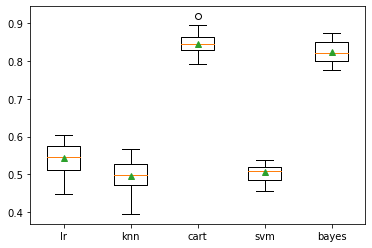

In [571]:
# get a list of models to evaluate

def get_models():
	models = {'lr': LogisticRegression()}
	models['knn'] = KNeighborsClassifier()
	models['cart'] = DecisionTreeClassifier()
	models['svm'] = SVC()
	models['bayes'] = GaussianNB()
	return models
 
# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
	return cross_val_score(
	    model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
 
# define dataset
X = train
y = train_labels

# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	scores = evaluate_model(model, X, y)
	results.append(scores)
	names.append(name)
	print('model %s accuracy: %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()



Based on results above, the highest accuracy score from the different models comes from bayes and Decision Tree Classifier.

so a closer look will be given to those two models. 

### Naïve Bayes Classifier
Naïve Bayes is a classification technique used to build classifier using the Bayes theorem. The assumption is that the predictors are independent. In simple words, it assumes that the presence of a particular feature in a class is unrelated to the presence of any other feature. which gives very good results, but in the medical field one thing has a high chance of being related to another. In this case Age and level of hemoglobin, if you get older the level of hemoglobin's gets reduced and can thus create blood pressure problems, which could be taken into account when using a bayes model for health prediction.

c:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


accuracy: 0.8601190476190477


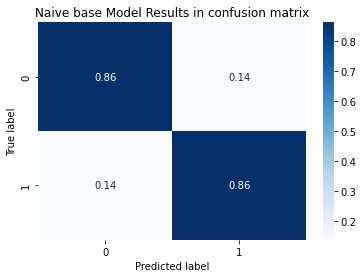

              precision    recall  f1-score   support

    diseased       0.85      0.86      0.86       163
     healthy       0.87      0.86      0.86       173

    accuracy                           0.86       336
   macro avg       0.86      0.86      0.86       336
weighted avg       0.86      0.86      0.86       336



In [572]:
# naive base model
bayes = GaussianNB()
model = bayes.fit(train, train_labels)
preds = bayes.predict(test)

print(f"accuracy: {accuracy_score(test_labels, preds)}")
cf_matrix = confusion_matrix(test_labels, preds)
# print(confusion_matrix)
# turn confusion matrix into percentages
df_cm = cf_matrix.astype('float') / cf_matrix.sum(axis=1)[:, np.newaxis] 
plt.figure()
heatmap = sns.heatmap(df_cm, cmap="Blues", annot=True)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Naive base Model Results in confusion matrix')
plt.show()  


print(classification_report(test_labels, preds))

#### Decision Tree Classifier
A decision tree is basically a binary tree flowchart where each node splits a group of observations according to some feature variable, which in this case is very useful as it can accurate separations between health parameters based on different thresholds for each parameter. this approach would give a more personalized prediction based on previous patient data. 

accuracy: 0.8065476190476191


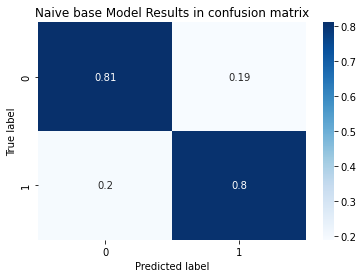

              precision    recall  f1-score   support

    diseased       0.80      0.81      0.80       163
     healthy       0.82      0.80      0.81       173

    accuracy                           0.81       336
   macro avg       0.81      0.81      0.81       336
weighted avg       0.81      0.81      0.81       336



In [573]:

cart = DecisionTreeClassifier()
model = cart.fit(train, train_labels)
preds = cart.predict(test)

print(f"accuracy: {accuracy_score(test_labels, preds)}")
# print(confusion_matrix(test_labels, preds))
cf_matrix = confusion_matrix(test_labels, preds)
# turn confusion matrix into percentages

df_cm = cf_matrix.astype('float') / cf_matrix.sum(axis=1)[:, np.newaxis] 
plt.figure()
heatmap = sns.heatmap(df_cm, cmap="Blues", annot=True)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Naive base Model Results in confusion matrix')
plt.show()  

print(classification_report(test_labels, preds))

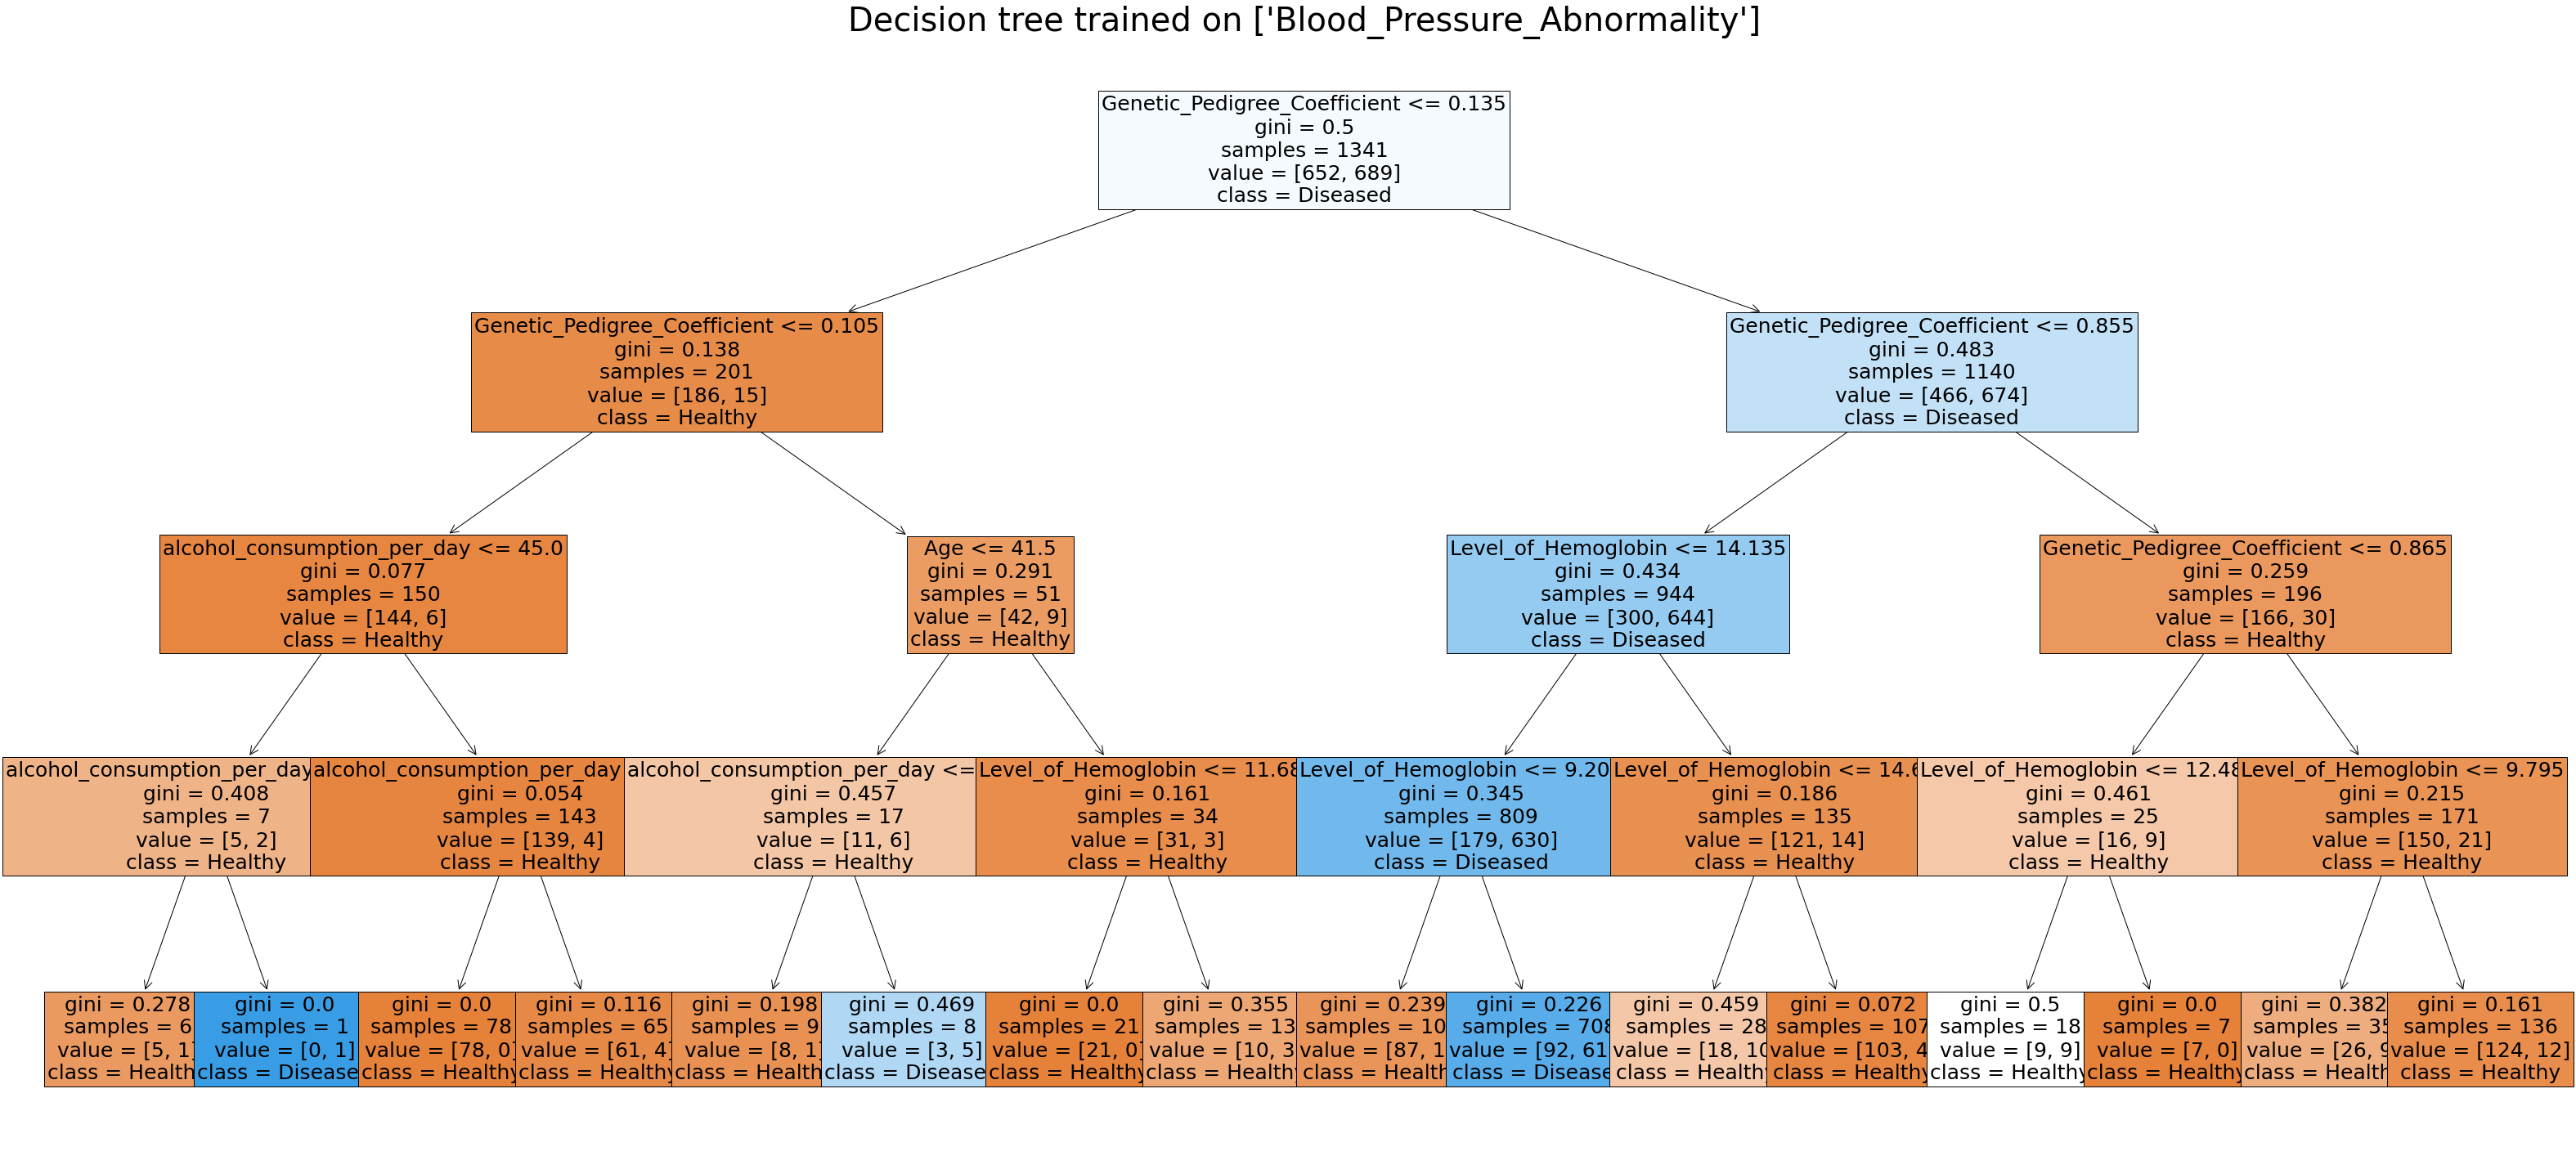

In [574]:
labels = ['Healthy', 'Diseased']
clf = tree.DecisionTreeClassifier(max_depth=4, random_state=42)
clf = clf.fit(X, y)
plt.figure(figsize=(55,25))
tree.plot_tree(clf, filled=True, fontsize=25, label='all',feature_names=feature_names, class_names=labels)
plt.title(f"Decision tree trained on {label_names}", fontsize=40)
plt.show()


Result: Looking at the difference between the bayes model and the Decision Tree, bayes seem to be the better choice as it has an overall higher precision, recall & f1-score. But the use of the model is domain based, so the ultimate decision on which model would be better suitable falls within its use. So yes bayes would be better model for pure prediction. But as a better fit for the purposed of personalized medicine idea, the Decision Tree would be the better choice as it can give better prediction based on specific situations. 

#### Stacking models

Stacking or Stacked Generalization is an ensemble machine learning algorithm.
It uses a meta-learning algorithm to learn how to best combine the predictions from two or more base machine learning algorithms.
The benefit of stacking is that it can harness the capabilities of a range of well-performing models on a classification or regression task and make predictions that have better performance than any single model in the ensemble.

model lr accuracy: 0.542  (0.038)
model knn accuracy: 0.497  (0.041)
model cart accuracy: 0.839  (0.026)
model svm accuracy: 0.506  (0.020)
model bayes accuracy: 0.825  (0.028)
model stacking accuracy: 0.874  (0.024)


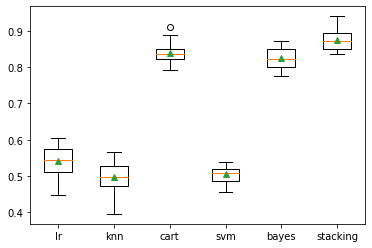

In [575]:
# get a stacking ensemble of models
def get_stacking():
	# define the base models
	level0 = [('lr', LogisticRegression())]
	level0.append(('knn', KNeighborsClassifier()))
	level0.append(('cart', DecisionTreeClassifier()))
	level0.append(('svm', SVC()))
	level0.append(('bayes', GaussianNB()))
	# define meta learner model
	level1 = LogisticRegression()
	# define the stacking ensemble
 
	model = StackingClassifier(estimators=level0, final_estimator=level1, cv=5)
	return model
 
# get a list of models to evaluate
def get_models():
	models = {'lr': LogisticRegression()}
	models['knn'] = KNeighborsClassifier()
	models['cart'] = DecisionTreeClassifier()
	models['svm'] = SVC()
	models['bayes'] = GaussianNB()
	models['stacking'] = get_stacking()
	return models
 
# evaluate a give model using cross-validation
def evaluate_model(model, X, y):
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
	return cross_val_score(
	    model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
 
# define dataset
X = train
y = train_labels
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	scores = evaluate_model(model, X, y)
	results.append(scores)
	names.append(name)
	print('model %s accuracy: %.3f  (%.3f)' % (name, np.mean(scores), np.std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

In [576]:
stack = get_stacking()
model = stack.fit(train, train_labels)
preds = stack.predict(test)

print(f"accuracy: {accuracy_score(test_labels, preds)}")
print(confusion_matrix(test_labels, preds))
print(classification_report(test_labels, preds))

c:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


accuracy: 0.8601190476190477
[[143  20]
 [ 27 146]]
              precision    recall  f1-score   support

    diseased       0.84      0.88      0.86       163
     healthy       0.88      0.84      0.86       173

    accuracy                           0.86       336
   macro avg       0.86      0.86      0.86       336
weighted avg       0.86      0.86      0.86       336



Result: Stacking the models increases the accuracy of the model by about 